In [1]:
# Importing the Keras libraries and packages

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

train_dir = "/kaggle/input/american-sign-language-recognition/training_set"
eval_dir = "/kaggle/input/american-sign-language-recognition/test_set"

# 2. Loading the data

In [3]:
#Helper function to load images from given directories
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [4]:
import keras

uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(directory = eval_dir)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  40
Number of training images:  48281
Number of testing images:  12071
Number of evaluation images:  8000


In [7]:
uniq_labels

['1',
 '10',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'best of luck',
 'fuck you',
 'i love you',
 'space']

# 3. Preprocessing: One-hot enconding the data

This conversion will turn the one-dimensional array of labels into a two-dimensional array. Each row in the two-dimensional array of one-hot encoded labels corresponds to a different label.

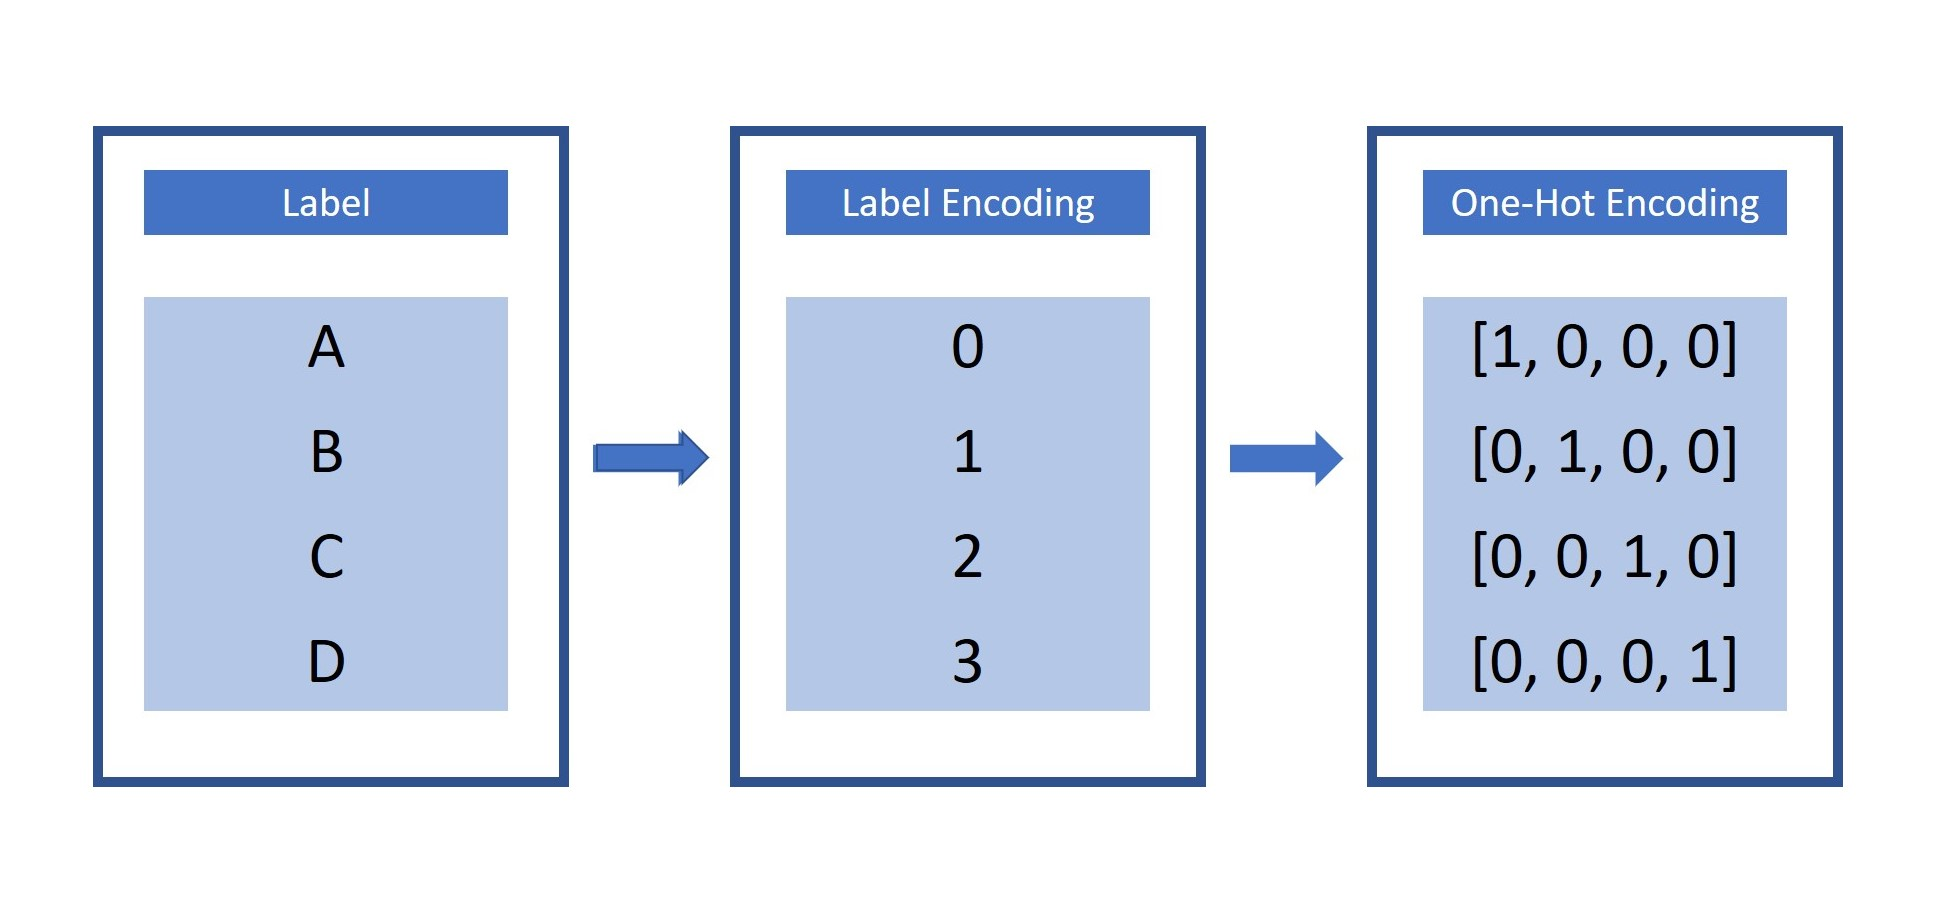

In [8]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

now just checking that is it converted or not.

In [9]:
print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
40


# 4. Preprocessing

**Normalization will help us remove distortions caused by lights and shadows in an image**

In [10]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

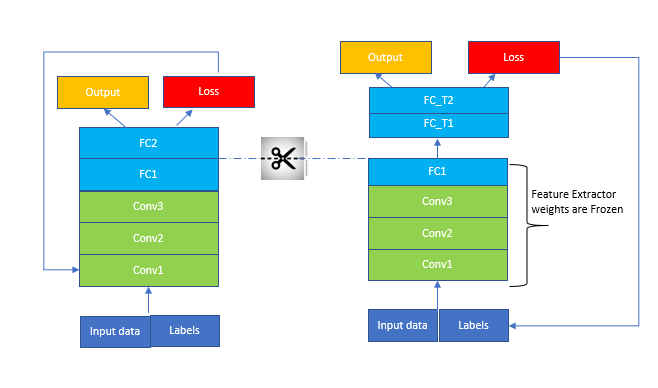

# initializing all the models

VGG16

In [11]:
#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


# Architecture of RESNET50

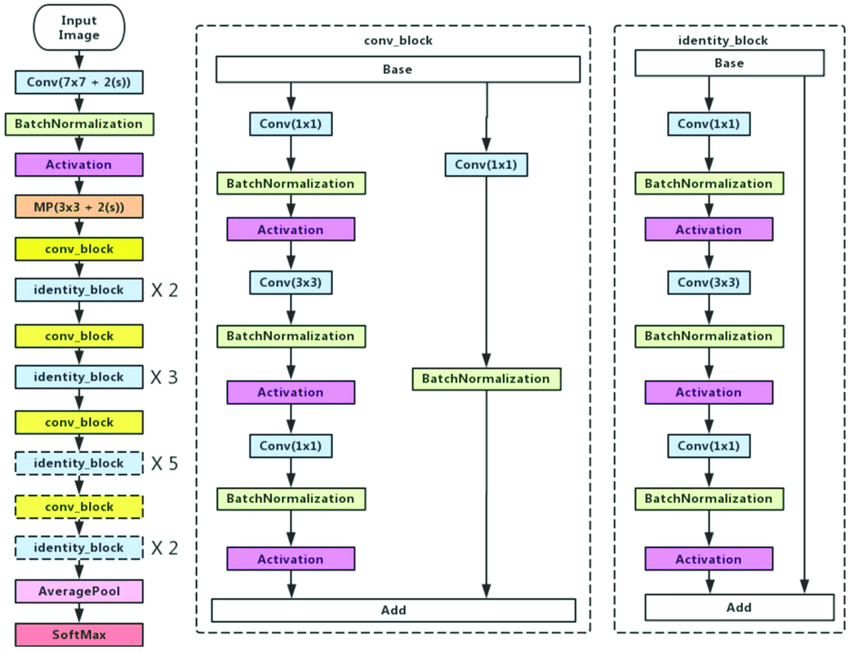

In [12]:
#Initialising vgg16 
classifier_resnet = ResNet50(input_shape= (64,64,3),include_top=False,weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

#don't train existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

In [15]:
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=40, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
from tensorflow.keras.optimizers import Adam


classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=40, activation='softmax')(classifier2)


model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [27]:
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [19]:
#fit the model
#it will take some time to train
history = model.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
755/755 [==============================] - 17s 23ms/step - loss: 0.2410 - accuracy: 0.9500 - val_loss: 0.0024 - val_accuracy: 0.9999
Epoch 2/5
755/755 [==============================] - 16s 22ms/step - loss: 0.0120 - accuracy: 0.9986 - val_loss: 2.5325e-04 - val_accuracy: 1.0000
Epoch 3/5
755/755 [==============================] - 17s 23ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 9.5794e-05 - val_accuracy: 1.0000
Epoch 4/5
755/755 [==============================] - 17s 22ms/step - loss: 0.0047 - accuracy: 0.9994 - val_loss: 3.7663e-05 - val_accuracy: 1.0000
Epoch 5/5
755/755 [==============================] - 17s 22ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 1.8526e-05 - val_accuracy: 1.0000


In [28]:
#fit the model
#it will take some time to train
history2 = model2.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
755/755 [==============================] - 18s 24ms/step - loss: 0.4271 - accuracy: 0.9179 - val_loss: 0.0481 - val_accuracy: 0.9968
Epoch 2/5
755/755 [==============================] - 17s 22ms/step - loss: 0.0775 - accuracy: 0.9872 - val_loss: 0.0172 - val_accuracy: 0.9990
Epoch 3/5
755/755 [==============================] - 17s 22ms/step - loss: 0.0484 - accuracy: 0.9911 - val_loss: 0.0098 - val_accuracy: 0.9992
Epoch 4/5
755/755 [==============================] - 17s 22ms/step - loss: 0.0360 - accuracy: 0.9929 - val_loss: 0.0064 - val_accuracy: 0.9993
Epoch 5/5
755/755 [==============================] - 17s 22ms/step - loss: 0.0313 - accuracy: 0.9926 - val_loss: 0.0044 - val_accuracy: 0.9997


In [29]:
# Saving the model of vgg16
model.save('model_vgg16.h5')
# Saving the model of resnet
model2.save('model_resnet.h5')

Accuracy of **VGG16**

In [30]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 100.0 %
Accuracy for evaluation images: 100.0 %


Accuracy of **RESNET50**

In [31]:
score = model2.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model2.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 99.967 %
Accuracy for evaluation images: 100.0 %


VGG16 accuracy and loss plot

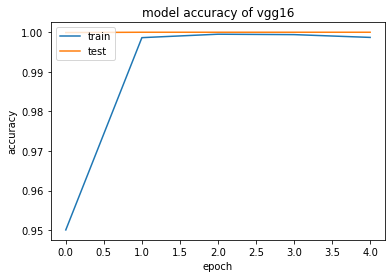

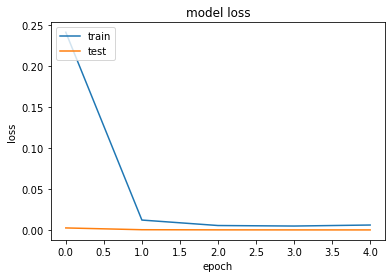

In [32]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

resnet50 accuracy and loss plot

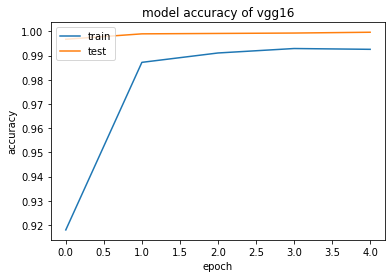

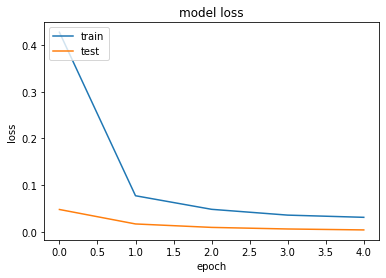

In [33]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# VGG16 confusion matrix

 This will be the matrix for the testing data, which gave a high accuracy. We expect to find the diagonal elements to have large values with some values distributed in non-diagonal elements. Note that our the matrix is not normalized, and the total number of testing images per label were 300.

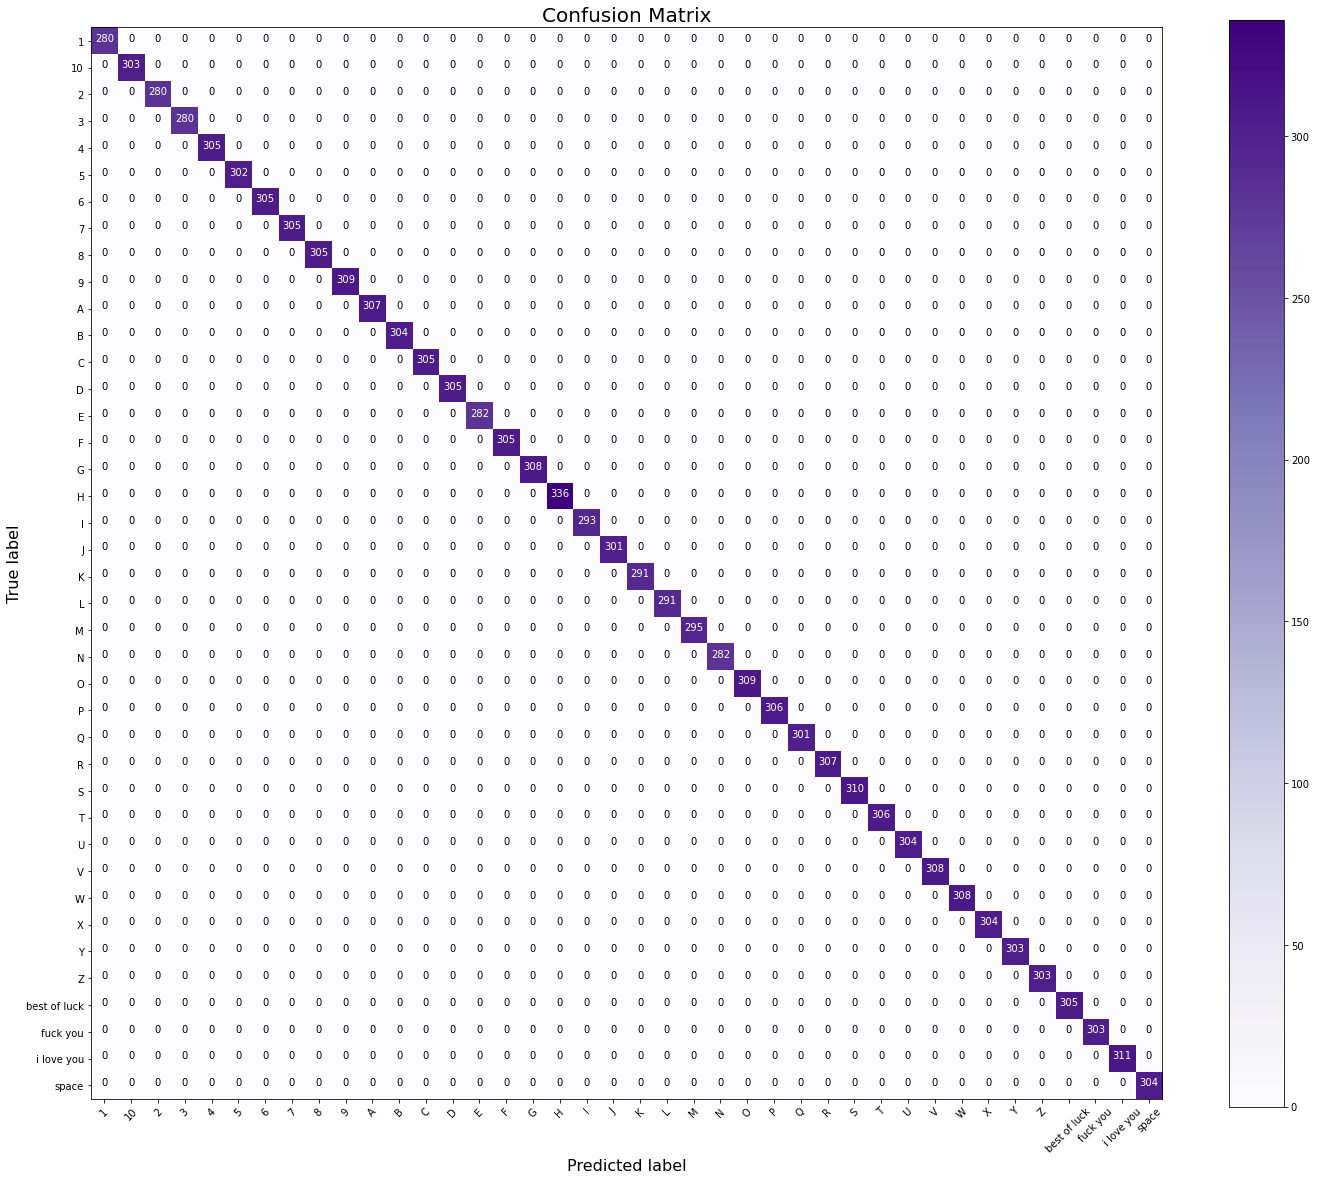

In [34]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

**Next I will plot the confusion matrix for the evaluation images**

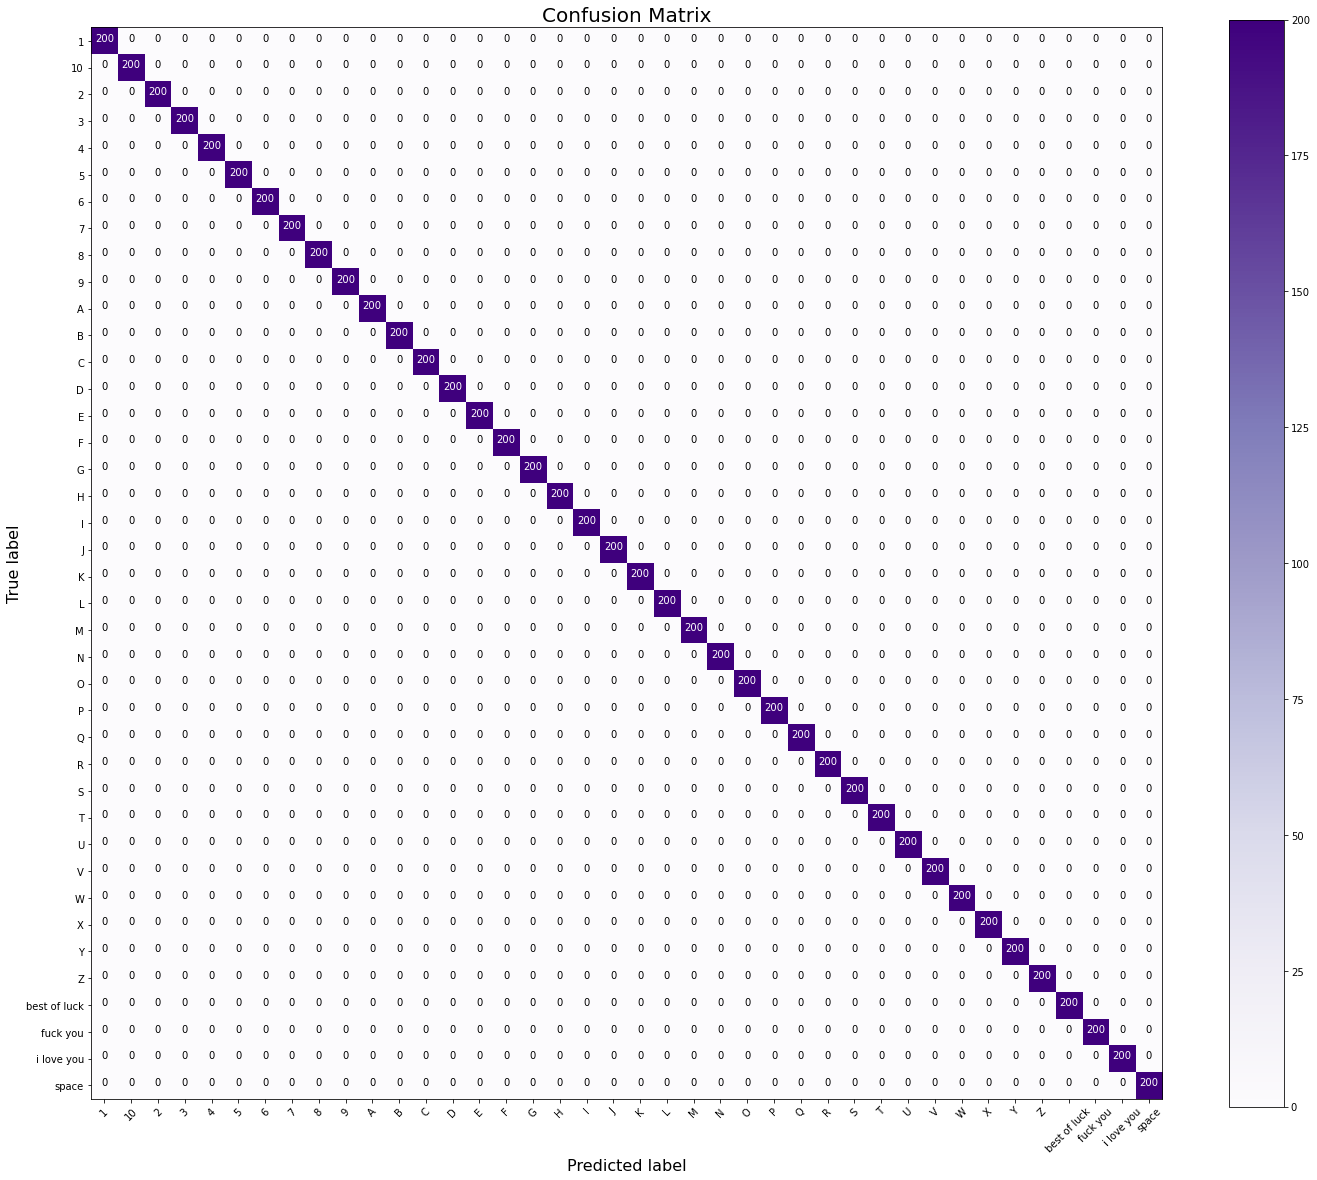

In [35]:
y_eval_pred = model.predict(X_eval, batch_size = 512,verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

# RESNET50 confusion matrix

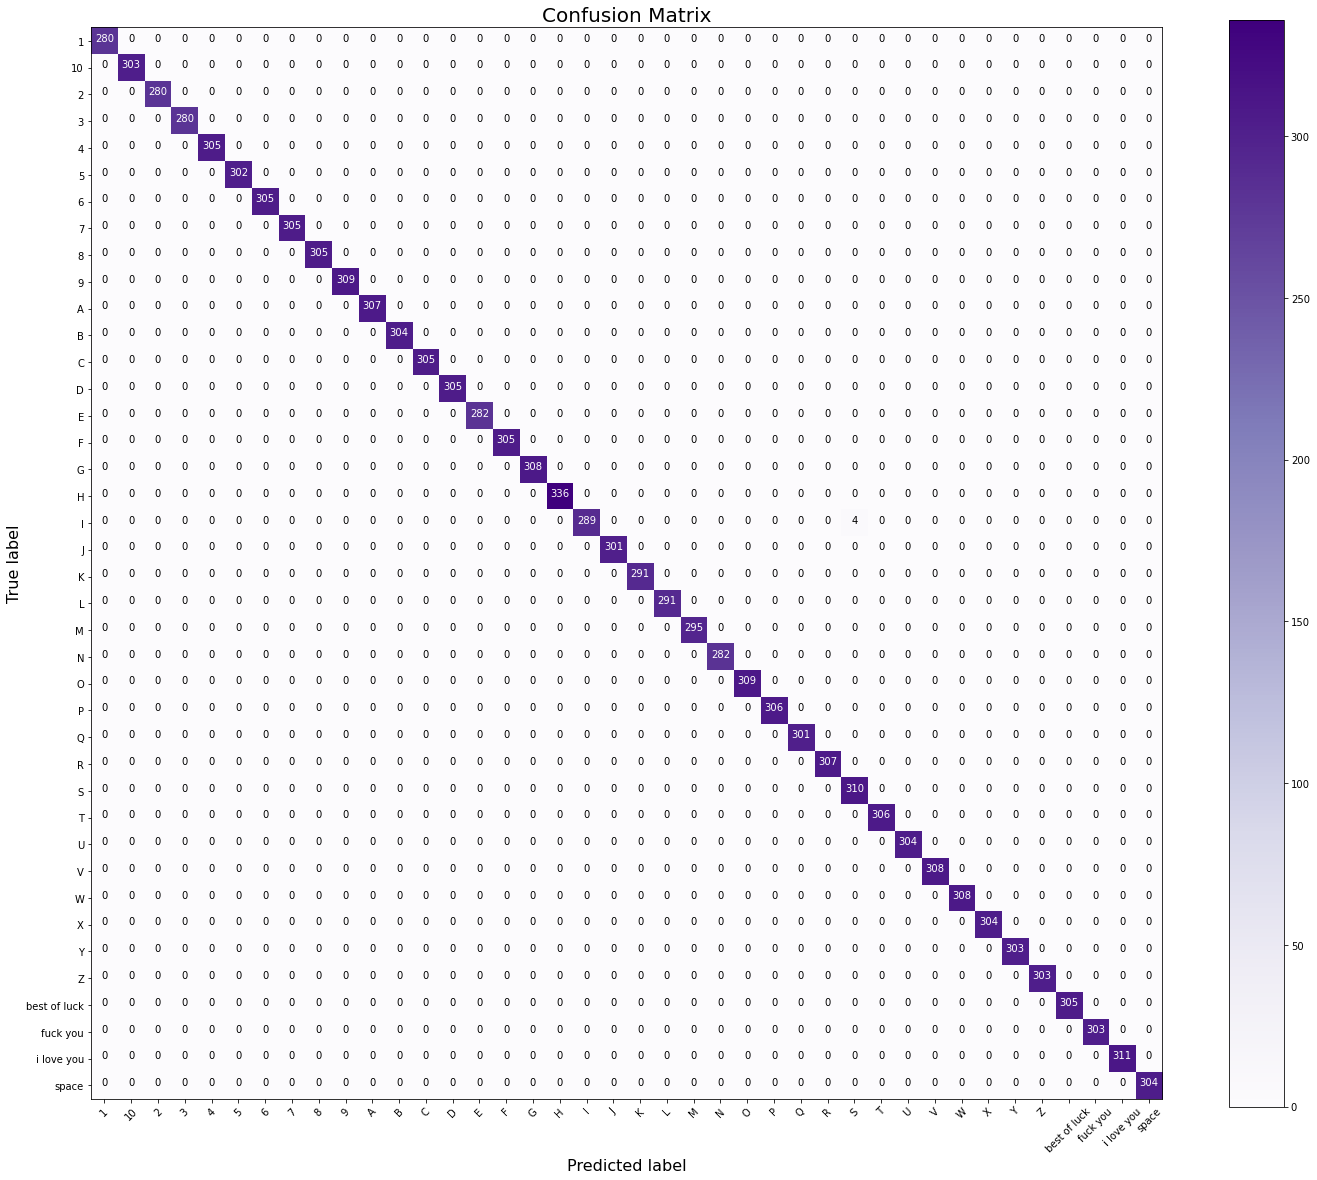

In [36]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model2.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

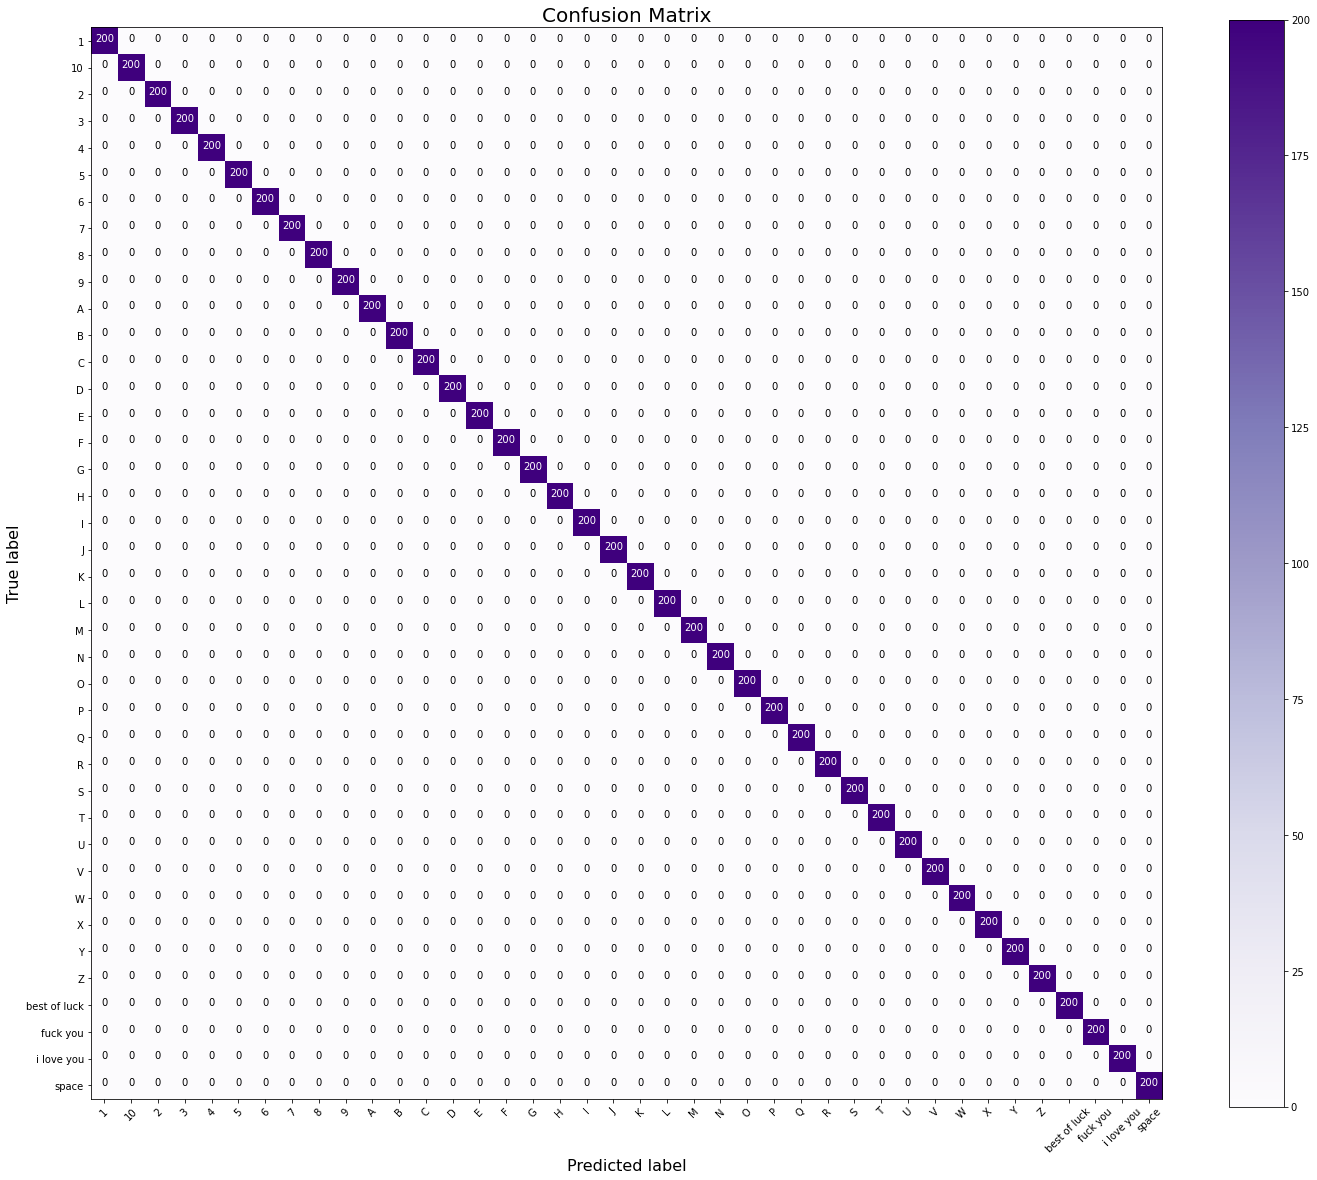

In [37]:
y_eval_pred = model2.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

i love you


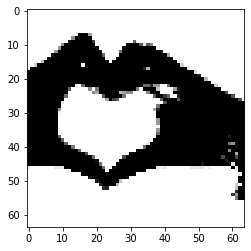

In [42]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/kaggle/input/american-sign-language-recognition/test_set/i love you/1.png',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)


if result[0][0] == 1:
    prediction = '1'
elif result[0][1] == 1:
    prediction = '10'
elif result[0][2] == 1:
    prediction = '2'
elif result[0][3] == 1:
    prediction = '3'
elif result[0][4] == 1:
    prediction = '4'
elif result[0][5] == 1:
    prediction = '5'
elif result[0][6] == 1:
    prediction = '6'
elif result[0][7] == 1:
    prediction = '7'
elif result[0][8] == 1:
    prediction = '8'
elif result[0][9] == 1:
    prediction = '9'
elif result[0][10] == 1:
    prediction = 'A'
elif result[0][11] == 1:
    prediction = 'B'
elif result[0][12] == 1:
    prediction = 'C'
elif result[0][13] == 1:
    prediction = 'D'
elif result[0][14] == 1:
    prediction = 'E'
elif result[0][15] == 1:
    prediction = 'F'
elif result[0][16] == 1:
    prediction = 'G'
elif result[0][17] == 1:
    prediction = 'H'
elif result[0][18] == 1:
    prediction = 'I'
elif result[0][19] == 1:
    prediction = 'J'
elif result[0][20] == 1:
    prediction = 'K'
elif result[0][21] == 1:
    prediction = 'L'
elif result[0][22] == 1:
    prediction = 'M'
elif result[0][23] == 1:
    prediction = 'N'
elif result[0][24] == 1:
    prediction = 'O'
elif result[0][25] == 1:
    prediction = 'P'
elif result[0][26] == 1:
    prediction = 'Q'
elif result[0][27] == 1:
    prediction = 'R'
elif result[0][28] == 1:
    prediction = 'S'
elif result[0][29] == 1:
    prediction = 'T'
elif result[0][30] == 1:
    prediction = 'U'
elif result[0][31] == 1:
    prediction = 'V'
elif result[0][32] == 1:
    prediction = 'W'
elif result[0][33] == 1:
    prediction = 'X'
elif result[0][34] == 1:
    prediction = 'Y'
elif result[0][35] == 1:
    prediction = 'Z'
elif result[0][36] == 1:
    prediction = 'best of luck'
elif result[0][37] == 1:
    prediction = 'fuck you'
elif result[0][38] == 1:
    prediction = 'i love you'
else:
    prediction = '  '
    
print(prediction)

space


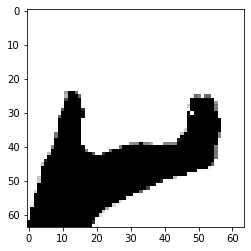

In [43]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/kaggle/input/american-sign-language-recognition/test_set/space/10.png',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model2.predict(test_image)


if result[0][0] == 1:
    prediction = '1'
elif result[0][1] == 1:
    prediction = '10'
elif result[0][2] == 1:
    prediction = '2'
elif result[0][3] == 1:
    prediction = '3'
elif result[0][4] == 1:
    prediction = '4'
elif result[0][5] == 1:
    prediction = '5'
elif result[0][6] == 1:
    prediction = '6'
elif result[0][7] == 1:
    prediction = '7'
elif result[0][8] == 1:
    prediction = '8'
elif result[0][9] == 1:
    prediction = '9'
elif result[0][10] == 1:
    prediction = 'A'
elif result[0][11] == 1:
    prediction = 'B'
elif result[0][12] == 1:
    prediction = 'C'
elif result[0][13] == 1:
    prediction = 'D'
elif result[0][14] == 1:
    prediction = 'E'
elif result[0][15] == 1:
    prediction = 'F'
elif result[0][16] == 1:
    prediction = 'G'
elif result[0][17] == 1:
    prediction = 'H'
elif result[0][18] == 1:
    prediction = 'I'
elif result[0][19] == 1:
    prediction = 'J'
elif result[0][20] == 1:
    prediction = 'K'
elif result[0][21] == 1:
    prediction = 'L'
elif result[0][22] == 1:
    prediction = 'M'
elif result[0][23] == 1:
    prediction = 'N'
elif result[0][24] == 1:
    prediction = 'O'
elif result[0][25] == 1:
    prediction = 'P'
elif result[0][26] == 1:
    prediction = 'Q'
elif result[0][27] == 1:
    prediction = 'R'
elif result[0][28] == 1:
    prediction = 'S'
elif result[0][29] == 1:
    prediction = 'T'
elif result[0][30] == 1:
    prediction = 'U'
elif result[0][31] == 1:
    prediction = 'V'
elif result[0][32] == 1:
    prediction = 'W'
elif result[0][33] == 1:
    prediction = 'X'
elif result[0][34] == 1:
    prediction = 'Y'
elif result[0][35] == 1:
    prediction = 'Z'
elif result[0][36] == 1:
    prediction = 'best of luck'
elif result[0][37] == 1:
    prediction = 'fuck you'
elif result[0][38] == 1:
    prediction = 'i love you'
else:
    prediction = 'space'
    
print(prediction)

i love you


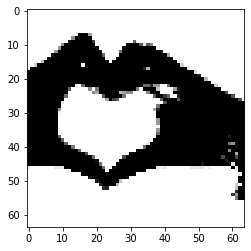

In [45]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/kaggle/input/american-sign-language-recognition/test_set/i love you/1.png',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)


if result[0][0] == 1:
    prediction = '1'
elif result[0][1] == 1:
    prediction = '10'
elif result[0][2] == 1:
    prediction = '2'
elif result[0][3] == 1:
    prediction = '3'
elif result[0][4] == 1:
    prediction = '4'
elif result[0][5] == 1:
    prediction = '5'
elif result[0][6] == 1:
    prediction = '6'
elif result[0][7] == 1:
    prediction = '7'
elif result[0][8] == 1:
    prediction = '8'
elif result[0][9] == 1:
    prediction = '9'
elif result[0][10] == 1:
    prediction = 'A'
elif result[0][11] == 1:
    prediction = 'B'
elif result[0][12] == 1:
    prediction = 'C'
elif result[0][13] == 1:
    prediction = 'D'
elif result[0][14] == 1:
    prediction = 'E'
elif result[0][15] == 1:
    prediction = 'F'
elif result[0][16] == 1:
    prediction = 'G'
elif result[0][17] == 1:
    prediction = 'H'
elif result[0][18] == 1:
    prediction = 'I'
elif result[0][19] == 1:
    prediction = 'J'
elif result[0][20] == 1:
    prediction = 'K'
elif result[0][21] == 1:
    prediction = 'L'
elif result[0][22] == 1:
    prediction = 'M'
elif result[0][23] == 1:
    prediction = 'N'
elif result[0][24] == 1:
    prediction = 'O'
elif result[0][25] == 1:
    prediction = 'P'
elif result[0][26] == 1:
    prediction = 'Q'
elif result[0][27] == 1:
    prediction = 'R'
elif result[0][28] == 1:
    prediction = 'S'
elif result[0][29] == 1:
    prediction = 'T'
elif result[0][30] == 1:
    prediction = 'U'
elif result[0][31] == 1:
    prediction = 'V'
elif result[0][32] == 1:
    prediction = 'W'
elif result[0][33] == 1:
    prediction = 'X'
elif result[0][34] == 1:
    prediction = 'Y'
elif result[0][35] == 1:
    prediction = 'Z'
elif result[0][36] == 1:
    prediction = 'best of luck'
elif result[0][37] == 1:
    prediction = 'fuck you'
elif result[0][38] == 1:
    prediction = 'i love you'
else:
    prediction = '  '
    
print(prediction)

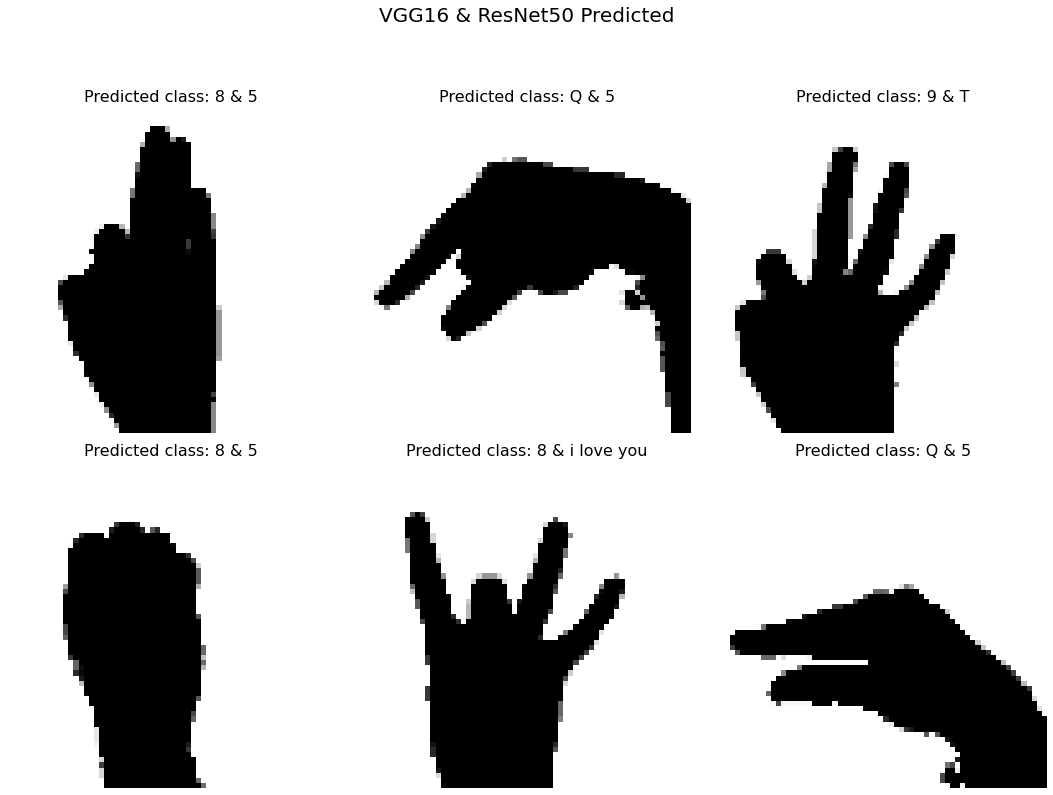

In [46]:
#vgg16 and resnet to prediction
import os
import random
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

folder_path = '/kaggle/input/american-sign-language-recognition/test_set'

# Lấy danh sách tất cả các thư mục con trong thư mục test_set
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

# Chọn ngẫu nhiên 6 thư mục
random_subfolders = random.sample(subfolders, 6)


# Tạo một subplot với 2 hàng và 3 cột
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))


# Hiển thị ảnh từ các thư mục được chọn

for i, folder in enumerate(random_subfolders):
    file_list = os.listdir(folder)
    random_image_name = random.choice(file_list)
    image_path = os.path.join(folder, random_image_name)

    # Load và hiển thị ảnh
    test_image = image.load_img(image_path, target_size=(64, 64))
    ax = axes[i // 3, i % 3]  # Lấy ô subplot thích hợp
    ax.imshow(test_image)
    ax.axis('off')

    # Dự đoán ảnh
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)
    # resnet50
    result2 = model2.predict(test_image)

    # Lấy nhãn dự đoán
    prediction = np.argmax(result)
    #
    prediction2 = np.argmax(result2)
    class_labels = ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'best of luck', 'fuck you', 'i love you', 'unknow']
    prediction_label = class_labels[prediction]
    #
    prediction_label2 = class_labels[prediction2]


    # In nhãn dự đoán
    ax.set_title("Predicted class: " + prediction_label + " & " + prediction_label2, fontsize=16)

fig.suptitle("VGG16 & ResNet50 Predicted", fontsize=20, y=1.1)
plt.tight_layout()
plt.show()
